From the dawn of Big Bills, there has been one question that has torn the band in two. The heated debates have turned Montucky Cold Snacks into Montucky Warm Snacks. Warm Peebers have been made into even warmer (yet still refreshing) Peebers. Joe, out of frustration, played the drums louder and lounder, and Mitch, with his sensitive ears, couldn't take it any longer. So Mitch set out to answer the ultimate question - Is "Take Me Home, Country Roads" a banger?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/songAttributes_1999-2019.csv
/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/artistDf.csv
/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/grammyAlbums_199-2019.csv
/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/grammySongs_1999-2019.csv
/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/spotifyWeeklyTop200Streams.csv
/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/riaaSingleCerts_1999-2019.csv
/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/billboardHot100_1999-2019.csv
/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/riaaAlbumCerts_1999-2019.csv


First, we're going to import in Billboard's Top 100 from years 1999-2019.

In [2]:
# import the data
path = r'/kaggle/input/data-on-songs-from-billboard-19992019/BillboardFromLast20/billboardHot100_1999-2019.csv'
bb_data = pd.read_csv(path, index_col=0)
bb_data.tail()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
97221,Vitamin C,Smile,95,NaN,NaN,1999-07-12,NaN,"Jamaica,Pop","Colleen fitzpatrick, Josh deutsch","Smile \nHahaha\nAlright, yeah\nAlright\nFirst ...",Lady Saw
97222,Collective Soul,Heavy,96,73.0,20.0,1999-07-12,NaN,"Hockey,Gaming,Soundtrack,Rock",Collective soul,Heavy \nComplicate this world you wrapped for ...,NaN
97223,Mary Chapin Carpenter,Almost Home,97,NaN,NaN,1999-07-12,NaN,"Country,Pop","Annie roboff, Beth nielsen chapman, Mary chapi...",Almost Home \nI saw my life this morning\nLyin...,NaN
97224,Q,Vivrant Thing,98,NaN,NaN,1999-07-12,NaN,Rap,"Q tip, J dilla, Barry white",Vivrant Thing \nUh check it out now\nUh no dou...,NaN
97225,The Offspring,Why Don't You Get A Job?,100,74.0,15.0,1999-07-12,NaN,"Ska,Punk Rock,Rock",Dexter holland,Why Don't You Get a Job? \nMy friend's got a g...,NaN


We're primarily concerned with Country Bangers, so let's filter out all songs that aren't country.

In [3]:
# Filter to only country songs
columns = ['Artists', 'Name', 'Weekly.rank', 'Peak.position', 'Lyrics']
country_songs = bb_data[bb_data.Genre.str.contains('Country', regex=False)][columns].copy()
country_songs

,Artists,Name,Weekly.rank,Peak.position,Lyrics
1,"Lil Nas,",Old Town Road,1,1.0,"Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm..."
18,Blake Shelton,God's Country,18,18.0,God's Country \nRight outside of this one chur...
22,"Lil Nas X, Cardi B",Rodeo,22,NaN,"Rodeo \nDaytrip took it to 10 Hey\nOh, here we..."
26,Lee Brice,Rumor,26,25.0,Rumor \nGirl you know I've known you forever\n...
28,Morgan Wallen,Whiskey Glasses,28,17.0,"Whiskey Glasses \nPoor me, pour me another dri..."
...,...,...,...,...,...
97207,Shania Twain,You've Got A Way,80,NaN,You've Got a Way \nYou've got a way with me\nS...
97208,Mark Wills,Wish You Were Here,81,34.0,Wish You Were Here \nThey kissed goodbye at th...
97213,Shania Twain,Man! I Feel Like A Woman!,86,34.0,"Man! I Feel like a Woman! \nLet's go, girls!\n..."
97215,Collin Raye,Anyone Else,88,37.0,Anyone Else \nBaby I bought wine and roses on ...


We can see that some songs have a peak position of NaN (not a number). That simply won't do. Let's calculate the missing values.

In [4]:
###
# Calculating Peak.position
###
from time import perf_counter
new_peak_positions = country_songs.groupby(['Artists','Name']).agg(min_rank=('Weekly.rank', min))


def newPeak(row):
    ndx = (row['Artists'], row['Name'])
    new_peak_position = new_peak_positions.loc[ndx, 'min_rank']
    if np.isnan(row["Peak.position"]):
        row["Peak.position"] = new_peak_position
    else:
        new_min = min(row["Peak.position"], new_peak_position)
        row["Peak.position"] = new_min
    return row["Peak.position"]

start = perf_counter()
country_songs["Peak.position"] = country_songs.apply(newPeak, axis=1)
stop = perf_counter()
print("Time to calculate new peak position:", stop-start) 
country_songs.head()

Time to calculate new peak position: 10.97845719199995


,Artists,Name,Weekly.rank,Peak.position,Lyrics
1,"Lil Nas,",Old Town Road,1,1.0,"Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm..."
18,Blake Shelton,God's Country,18,18.0,God's Country \nRight outside of this one chur...
22,"Lil Nas X, Cardi B",Rodeo,22,22.0,"Rodeo \nDaytrip took it to 10 Hey\nOh, here we..."
26,Lee Brice,Rumor,26,25.0,Rumor \nGirl you know I've known you forever\n...
28,Morgan Wallen,Whiskey Glasses,28,17.0,"Whiskey Glasses \nPoor me, pour me another dri..."


Much better.

Now let's start talking about our methods. To define a banger, we're going to go with what The People say. Sure, some of The People are real Soglins and don't have an innate sense for bangers, but that's the data we have and we're going to use it.

We can define our Critical Banger Zone to separate our bangers from our bops.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


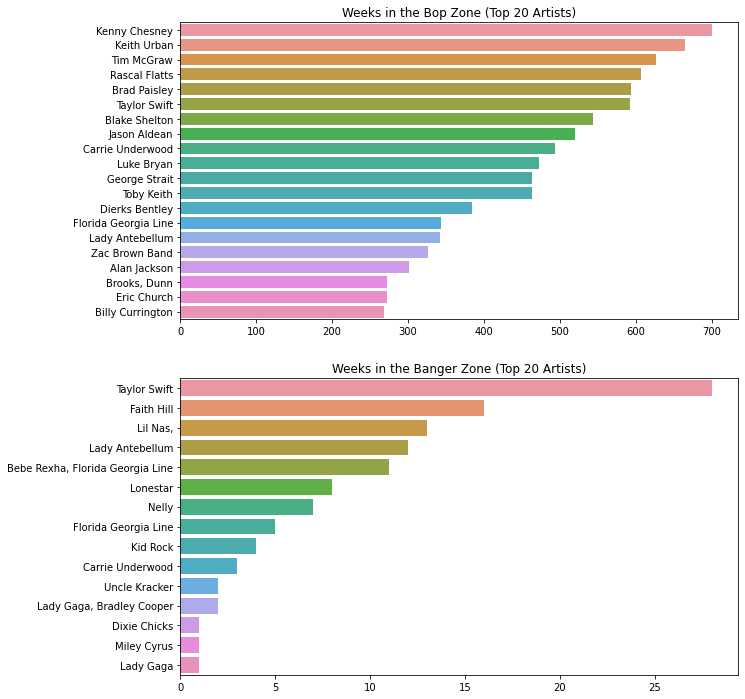

In [5]:
# Define the billboard rank for critical banger zone
highway_to_the_banger_zone = 5

# Separate by weekly rank
country_bangers = country_songs[bb_data['Weekly.rank'] <= highway_to_the_banger_zone]
country_bops = country_songs[bb_data['Weekly.rank'] > highway_to_the_banger_zone]

# import plotting modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# who has spent the most time on the charts?
bopzone_weeks = country_bops['Artists'].value_counts()[0:20]
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,12))
ax1.set_title("Weeks in the Bop Zone (Top 20 Artists)")
sns.barplot(y=bopzone_weeks.index, x=bopzone_weeks.values, ax=ax1)

# who has spent the most time in banger zone?
bangerzone_weeks = country_bangers['Artists'].value_counts()[0:20]
ax2.set_title("Weeks in the Banger Zone (Top 20 Artists)")
sns.barplot(y=bangerzone_weeks.index, x=bangerzone_weeks.values, ax=ax2)

The data thus far doesn't really show anything we didn't already know.
 - Taylor Swift... girl can write a song. Look at that banger to bop ratio!
 - FGL (split into two lines) is also a banger writing machine.
 - Nelly and Uncle Kracker are A-list country artists.
 

We'll turn this into a set of unique values and make sure Country Roads (1971) didn't crack the charts in the last two decades.

In [6]:
###
# Data Prep
### 

# Create a unique list of songs
columns = ['Artists', 'Name', 'Peak.position', 'Lyrics']
country_song_set = country_songs[columns].copy().drop_duplicates()

# Make sure Country Roads never made the charts
country_roads = country_song_set[country_song_set["Name"].str.contains("country road", case=False, regex=False)].loc[:,["Artists", "Name"]]
if country_roads.size == 0:
    print('"Take Me Home, Country Roads" did not make the billboards from 1999-2019')
else:
    print('"Take Me Home, Country Roads" did make the billboards from 1999-2019')

"Take Me Home, Country Roads" did not make the billboards from 1999-2019


Now lets prep the data for some real galaxy brain stuff. 

We're going to use Natrual Language Processing to see if we can identify a banger by the lyrics. To do so, we'll want to see how often each word appears in each song, but some words are "different" but really mean the same thing. Take the Big Bills Certified Banger "Save A Horse, Ride A Cowby". He "rides" into the city, but he's "riding" up in down broadway. Two words that really just mean "ride". For this, we turn to "lemmatizing".

Also, some words have more meaning than others. **Beer**, **trucks**, **horses**. Those have meaning. Words like *the, a, and, but* matter less. In NLP, we call these "stop words".

In [7]:
##
# Natural Language Processing - Introduction of terms
##

# Import NLP module
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# set up an example
test_string = country_song_set.loc[1, 'Lyrics']


# load the English language pipeline and tokenize the text string
nlp = spacy.load('en')
docx = nlp(test_string)

# demo of lemmatizing and stop words
lst = list()
dir(lst)
for word in docx:
    lst.append([word.text, word.lemma_, word.is_stop, word.is_punct, word.is_space])

# display the results
from tabulate import tabulate    
print(tabulate(lst[0:25], headers=['word', 'lemma', 'isStop', 'isPunct', 'isSpace']))


word    lemma    isStop    isPunct    isSpace
------  -------  --------  ---------  ---------
Old     Old      False     False      False
Town    Town     False     False      False
Road    Road     False     False      False
Remix   Remix    False     False      False
                 False     False      True
Oh      oh       False     False      False
,       ,        False     True       False
oh      oh       False     False      False
-       -        False     True       False
oh      oh       False     False      False
                 False     False      True
Oh      oh       False     False      False
                 False     False      True
Yeah    yeah     False     False      False
,       ,        False     True       False
I       -PRON-   True      False      False
'm      be       True      False      False
gon     go       False     False      False
na      to       False     False      False
take    take     True      False      False
my      -PRON-   True      Fa

In [8]:
###
# Is Country Roads a banger? - Create the tokenizer
###

# Create a method to preprocess the lyrics
def Tokenize(lyrics):
    # Create doc
    doc = nlp(lyrics)
    
    #lemmatize and remove stop words
    tokens = [word.lemma_.lower().strip() for word in doc if word.lemma_ != '-PRON-' and not word.is_stop and not word.is_punct and not word.is_space]
    return tokens
    
print(Tokenize(test_string))

['old', 'town', 'road', 'remix', 'oh', 'oh', 'oh', 'oh', 'yeah', 'go', 'to', 'horse', 'old', 'town', 'road', 'go', 'to', 'ride', 'til', 'go', 'to', 'horse', 'old', 'town', 'road', 'go', 'to', 'ride', 'til', 'kio', 'kio', 'get', 'horse', 'horse', 'tack', 'attach', 'hat', 'matte', 'black', 'get', 'boot', 'black', 'match', 'riding', 'horse', 'ha', 'whip', 'porsche', 'valley', 'be', 'porch', 'tell', 'nothing', 'tell', 'nothing', 'tell', 'nothing', 'tell', 'nothing', 'ride', 'tractor', 'lean', 'bladder', 'cheat', 'baby', 'ask', 'life', 'movie', 'bull', 'riding', 'boobie', 'cowboy', 'hat', 'gucci', 'wrangler', 'booty', 'tell', 'nothing', 'tell', 'nothing', 'tell', 'nothing', 'tell', 'nothing', 'yeah', 'go', 'to', 'horse', 'old', 'town', 'road', 'go', 'to', 'ride', 'til', 'go', 'to', 'horse', 'old', 'town', 'road', 'go', 'to', 'ride', 'til', 'hat', 'cross', 'town', 'live', 'like', 'rockstar', 'spend', 'lot', 'money', 'brand', 'new', 'guitar', 'baby', 'get', 'habit', 'diamond', 'ring', 'fendi'

Now let's train a model using all the lyrics. Before we feed in all the data, we want to evaluate how effective the model is. We'll train the model with 80% of the data and evaluate it against the remaining 20%. Here's what the data looks like.

In [9]:
# Create real data set
X = country_song_set['Lyrics']
y = country_song_set['Peak.position'] <= highway_to_the_banger_zone

# Split the data into testing and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# show sample from the train data
print('Train Data: IsBanger Counts\n---------------------------\n',y_train.value_counts())
print('\nTest Data: IsBanger Counts\n---------------------------\n',y_test.value_counts())
pd.concat([X_train, y_train], axis=1)

Train Data: IsBanger Counts
---------------------------
 False    995
True      17
Name: Peak.position, dtype: int64

Test Data: IsBanger Counts
---------------------------
 False    252
True       2
Name: Peak.position, dtype: int64


,Lyrics,Peak.position
33158,Cowboys And Angels \nThere's a want and there'...,False
87343,If You Can Do Anything Else \nWould you like t...,False
4258,"Get Along \nMet a man wearing a t-shirt, says ...",False
66555,Good Is Good \nGood is good and bad is bad\nYo...,False
39999,I Can't Love You Back \nI can love you in the ...,False
...,...,...
62845,The World \nA gun goes off in a far off city\n...,False
5080,I Lived It \nDaddy drove the wheels off a flat...,False
36162,I Don't Want This Night to End \nGirl I know I...,False
16099,Nobody to Blame \nShe took down the photograph...,False


Now we can train the model. Using the Bag of Words methodoly, we just turn this into a giant table where the count of words are represented as columns.

In [10]:
start = perf_counter()


# Use Bag of Words methodology (try TF-IDF later)
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow_vector = CountVectorizer(tokenizer = Tokenize, ngram_range=(1,1))


# For binary target, use logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)


# Create the bow pipeline and fit the model
from sklearn.pipeline import Pipeline
bow_pipe = Pipeline([("Vectorizer", bow_vector),
                 ("Classifier", model)])
bow_pipe.fit(X_train, y_train)


# Predict values using the trained model
y_predicted_bow = bow_pipe.predict(X_test)


# Measure performance
stop = perf_counter()
print("Time to train and evaluate model (in seconds):", stop-start) 

Time to train and evaluate model (in seconds): 75.32739723100076


Now we measure the performance.

In [11]:
# Create a confusion matrix
def ConfusionMatrix(lstPredictions, lstActual):
    tp = tn = fp = fn = 0
    for i in range(0, len(lstPredictions)):
        if lstPredictions[i] == True:
            if lstActual[i] == True: tp+=1
            else: fp+=1
        else:
            if lstActual[i] == False: tn+=1
            else: fn+=1
    return tp, tn, fp, fn


def EvalMetrics(tp, tn, fp, fn, display_results=True):
    # Model Accuracy - How often was the model right?
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitivity/Recall/TP Rate - How often do we correctly classify the bangers?
    sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # Specificity - How often did we correctly classify the bops?
    spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    # Precision - How certain are we that something that the model says is a banger is truly a banger?
    prec = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    if display_results:
        print("Model Accuracy - How often was the model right? - {0:.0%}".format(acc))
        print("Sensitivity/Recall/TP Rate - How often do we correctly classify the bangers? - {0:.0%}".format(sens))
        print("Specificity - How often did we correctly classify the bops? - {0:.0%}".format(spec))
        print("Precision - How certain are we that something that the model says is a banger is truly a banger? - {0:.0%}".format(prec))
    
    return {"Model Accuracy": acc, "Sensitivity":sens, "Specificity":spec, "Precision":prec}

tp, tn, fp, fn = ConfusionMatrix(y_predicted_bow, list(y_test))

print("(tp, tn,\n fp, fn)")
print(('({}, {},\n {}, {})\n\n'.format(tp, tn, fp, fn)))

dEval = EvalMetrics(tp, tn, fp, fn)


# When validating binary, use "metrics"  from scikit
from sklearn import metrics
print("\nsklearn.metrics\n---------------")
print("Accuracy (num correct / total):",metrics.accuracy_score(y_test, y_predicted_bow))
print("Sensitivity/Recall (true negs / all actual negs):",metrics.recall_score(y_test, y_predicted_bow))
print("Precision (true positives / all predicted positives):",metrics.precision_score(y_test, y_predicted_bow))

# 44, 98, 52, 60

(tp, tn,
 fp, fn)
(0, 251,
 1, 2)


Model Accuracy - How often was the model right? - 99%
Sensitivity/Recall/TP Rate - How often do we correctly classify the bangers? - 0%
Specificity - How often did we correctly classify the bops? - 100%
Precision - How certain are we that something that the model says is a banger is truly a banger? - 0%

sklearn.metrics
---------------
Accuracy (num correct / total): 0.9881889763779528
Sensitivity/Recall (true negs / all actual negs): 0.0
Precision (true positives / all predicted positives): 0.0


So the model tried guessing that song was a banger 1 out of the 254 guesses, and it was wrong. Really, this is a problem with training a model on such lopsided datasets. 

Let's try a Term Frequency - Inverse Document Frequency (TF-IDF) model. This method gives extra "weight" to words that appear more often in bangers.

In [12]:
###
# Try using TF-IDF
###
start = perf_counter()

# Create TF-IDF vectorizer
tfidf_vector = TfidfVectorizer(tokenizer = Tokenize, ngram_range=(1,1))

# Create the TF-IDF pipeline and fit the model
tfidf_pipe = Pipeline([("Vectorizer", tfidf_vector),
                 ("Classifier", model)])
tfidf_pipe.fit(X_train, y_train)


# Predict values using the trained model
y_predicted_tfidf = tfidf_pipe.predict(X_test)


# Measure Performance
stop = perf_counter()
print("Time to train and evaluate model (in seconds):", stop-start) 


tp, tn, fp, fn = ConfusionMatrix(y_predicted_tfidf, list(y_test))
print("(tp, tn,\n fp, fn)")
print(('({}, {},\n {}, {})\n\n'.format(tp, tn, fp, fn)))

dEval = EvalMetrics(tp, tn, fp, fn)

Time to train and evaluate model (in seconds): 74.34326065300047
(tp, tn,
 fp, fn)
(0, 252,
 0, 2)


Model Accuracy - How often was the model right? - 99%
Sensitivity/Recall/TP Rate - How often do we correctly classify the bangers? - 0%
Specificity - How often did we correctly classify the bops? - 100%
Precision - How certain are we that something that the model says is a banger is truly a banger? - 0%


It looks like this model just guessed that *all songs aren't bangers*. That doesn't do us any good.

But on second thought...

...did we just find the prefect model to evaluate if Country Roads is a banger?

In [13]:
country_roads_lyrics ='''
    Almost heaven, West Virginia
    Blue Ridge Mountains, Shenandoah River
    Life is old there, older than the trees
    Younger than the mountains, growing like a breeze
    Country roads, take me home
    To the place I belong
    West Virginia, mountain mama
    Take me home, country roads
    All my memories gather 'round her
    Miner's lady, stranger to blue water
    Dark and dusty, painted on the sky
    Misty taste of moonshine, teardrop in my eye
    Country roads, take me home
    To the place I belong
    West Virginia, mountain mama
    Take me home, country roads
    I hear her voice, in the morning hour she calls me
    The radio reminds me of my home far away
    Driving down the road, I get a feeling
    That I should have been home yesterday, yesterday
    Country roads, take me home
    To the place I belong
    West Virginia, mountain mama
    Take me home, country roads
    Country roads, take me home
    To the place I belong
    West Virginia, mountain mama
    Take me home, country roads
    Take me home, down country roads
    Take me home, down country roads'''

country_roads = [country_roads_lyrics]

# Train the model
tfidf_pipe_full = Pipeline([("Vectorizer", tfidf_vector),
                 ("Classifier", model)])
tfidf_pipe_full.fit(X, y)

# Predict if Country Roads is a banger
country_roads_isBanger = tfidf_pipe_full.predict(country_roads)

if country_roads_isBanger: print("Computers don't lie... Country Roads is a banger!")
else: print("Computers don't lie... Country Roads IS NOT a banger!")

Computers don't lie... Country Roads IS NOT a banger!


WELL THERE YA HAVE IT, BOYS!